# Feature Ablation to Inspect ResNet Decisions

This notebook tutorial demonstrates how feature ablation in Captum can be applied to inspect computer vision models.

本笔记本教程演示了如何应用 Captum 中的特征消融来检查计算机视觉模型。

**Task:** Classification into ImageNet-1k categories

**Model:** A ResNet18 trained on ImageNet-1k

**Data to inspect:** Samples from PASCAL VOC 2012

**Ablation based on:** Segmentation masks

We will use the visualization functions in Captum to show how each semantic part impacts the model output.

我们将使用 Captum 中的可视化功能来显示每个语义部分如何影响模型输出。

This tutorial assumes the following packages are installed: `captum`, `matplotlib`, `numpy`, `PIL`, `torch`, and `torchvision`.

In [58]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models

from captum.attr import visualization as viz
from captum.attr import FeatureAblation

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import json

## 1. Loading the model and the dataset

Let us load the pretrained `resnet18` model available in `torchvision` and set it to eval mode.

This model will serve as a classifier into the ImageNet-1k categories.

In [59]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet = resnet.eval()

A straightforward way to demonstrate feature ablation on images is to ablate semantic image areas.

Therefore, we will load sample images from PASCAL VOC, as these images come along with annotated segmentation masks.

**Note**: The VOC dataset is 2GB. If you do not want to download it, you can skip the next step and provide your own image and segmentation mask in the step next.

Let us look at a sample image along with its segmentation mask:

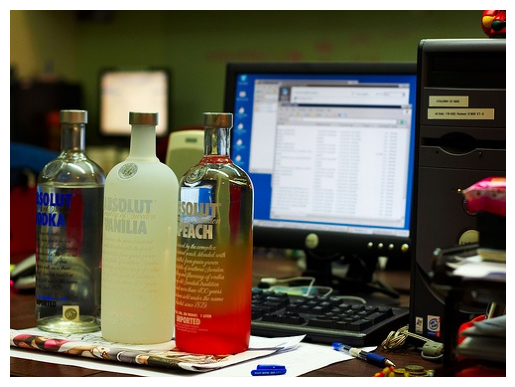

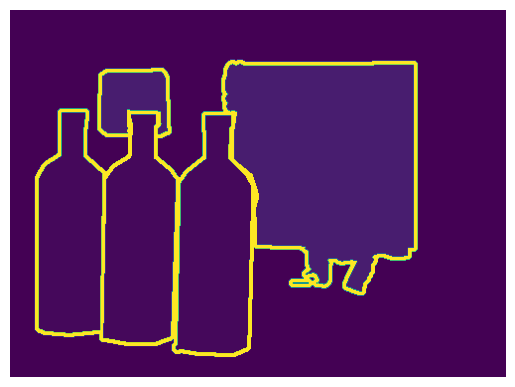

In [60]:
img = Image.open("images/2007_002953.jpg")
plt.imshow(img); plt.axis('off'); plt.show()
mask_img = Image.open("images/2007_002953.png")
plt.imshow(mask_img); plt.axis('off'); plt.show()

According to the segmentation mask, the image contains three bottles, and two TV monitors, with the rest considered background. All of `background`, `bottle`, and `tvmonitor` are among the 20 categories in PASCAL VOC 2012. This dataset also features a `void` category, used to annotate pixels that are not considered part of any class. These pixels represent border between the objects in the above example.

Let us also load ImageNet class labels to understand the output when we classify the samples using a classifier trained on ImageNet-1k.

**Note**: wget should be available as a command in your environment. You might need to install it. You can skip the next two steps if you are OK with class index as classification output (in that case, use `classify` in the next sections with `print_result`=`False`). 

In [61]:
# !wget -P assets/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-11-14 10:46:38--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.37.0, 54.231.138.16, 16.182.73.72, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.37.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: 'assets/models/imagenet_class_index.json.9'

     0K .......... .......... .......... ....                 100%  148K=0.2s

2023-11-14 10:46:39 (148 KB/s) - 'assets/models/imagenet_class_index.json.9' saved [35363/35363]



In [62]:
labels_path = './assets/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

## 2. Baseline classification

Let us define a function for classifying images using our ResNet. This model produces logits as classification scores. To normalize these logits into probabilities, we process the output with a `softmax` layer.

---

让我们定义一个使用 ResNet 对图像进行分类的函数。 该模型生成 logits 作为分类分数。 为了将这些 logits 标准化为概率，我们使用 `softmax` 层处理输出。

In [63]:
# uses torchvision transforms to convert a PIL image to a tensor and normalize it
img_to_resnet_input = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def classify(img, print_result=True):
    output = resnet(img_to_resnet_input(img).unsqueeze(0))
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    prediction_score.squeeze_()
    pred_label_idx.squeeze_()
    if print_result:
        labels_path = './assets/models/imagenet_class_index.json'
        with open(labels_path) as json_data:
            idx_to_labels = json.load(json_data)
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print('Predicted:', predicted_label, "id =", pred_label_idx.item(), 'with a score of:', prediction_score.squeeze().item())
    return pred_label_idx.item(), prediction_score.item()

Now, let us classify the image we loaded in the previous section:

In [64]:
predicted_class, prediction_score = classify(img)

Predicted: wine_bottle id = 907 with a score of: 0.13407425582408905


Our model classifies the image as the ImageNet-1k category `wine_bottle`. Not bad.

<em>Note that the model is trained for classification, and expects images containing one object not a whole scene.</em>

Now, let us see how different parts of the image influence this output.

## 3. Inspecting influential image parts behind the classification output

With the availability of a segmentation mask, we can quickly exclude parts of the image to see how they affect the classification output.

The Feature Ablation algorithm in Captum enables ablating a number of input features together as a group. This is very useful when dealing with images, where each color channel in each pixel is an input feature.
To define our desired groups over input features, all we need is to provide a <em>feature mask</em>.

In case of an image input, the feature mask is also a 2D image of the same size, where each pixel in the mask indicates the feature group it belongs to via an integer value. Pixels of the same value define a group.

This means we can readily use segmentation masks as feature masks in Captum!
Let us see how:

---

借助分割掩码，我们可以快速排除图像的某些部分，以了解它们如何影响分类输出。

Captum 中的特征消融算法可以将多个输入特征作为一个组消融在一起。 这在处理图像时非常有用，其中每个像素中的每个颜色通道都是一个输入特征。
要根据输入特征定义所需的组，我们需要的只是提供一个特征掩码。

在图像输入的情况下，特征掩模也是相同大小的2D图像，其中掩模中的每个像素通过整数值指示其所属的特征组。 具有相同值的像素定义一个组。

这意味着我们可以轻松使用分割掩码作为 Captum 中的特征掩码！
让我们看看如何：

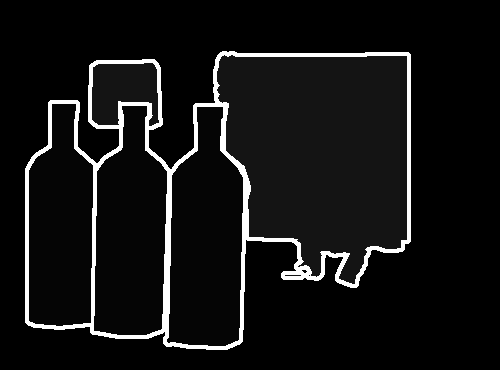

In [65]:
mask_img

In [66]:
# convert the mask image to a numpy array of the expected shape (count, channels, height, width)
feature_mask = np.array(mask_img).reshape(1, 1, mask_img.size[1], mask_img.size[0])
feature_mask.shape

(1, 1, 370, 500)

Our `feature_mask` is basically ready to use. However, let us first check its unique values that define the group ids:

In [67]:
np.unique(feature_mask)

array([  0,   5,  20, 255], dtype=uint8)

These ids correspond to the VOC labels for `background`, `bottle`, `tvmonitor` and `void`.

While they would work, Captum expects consecutive group ids and would hence consider that there are 256 feature groups (most of them empty). This would result in slow execution.

Let's instead map our groups to consecutive values as expected by Captum:

---

这些 id 对应于 `background`、`bottle`、`tvmonitor` 和`void` 的 VOC 标签。

虽然它们可以工作，但 Captum 期望连续的组 ID，因此会认为有 256 个功能组（其中大部分是空的）。 这会导致执行缓慢。

让我们按照 Captum 的预期将组映射到连续值：

In [68]:
feature_mask[feature_mask == 5] = 1 # feature group for bottle
feature_mask[feature_mask == 20] = 2 # feature group for tvmonitor
feature_mask[feature_mask == 255] = 3 # feature group for void

Now we can create our `FeatureAblation` object and use it to compute the influence of each feature group in our image on the target responsible for the `predicted_class` we computed in the previous section, which is `wine_bottle`

---

现在我们可以创建 `FeatureAblation` 对象，并使用它来计算图像中每个特征组对负责我们在上一节中计算的 `predicted_class`（即 `wine_bottle`）的目标的影响

In [69]:
ablator = FeatureAblation(forward_func=resnet)

attribution_map = ablator.attribute(
    inputs=img_to_resnet_input(img).unsqueeze(0),
    target=predicted_class,
    feature_mask=torch.tensor(feature_mask)
)
attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels
attribution_map = np.transpose(attribution_map, (1, 2, 0))
attribution_map.shape

(370, 500, 3)

Let us visualize the resulting attribution map:

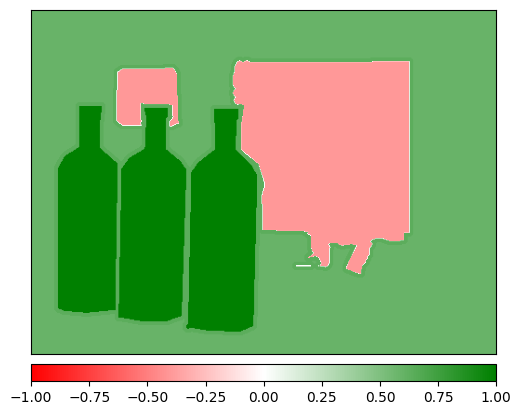

In [70]:
_ = viz.visualize_image_attr(
    attr=attribution_map,
    method="heat_map",  # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    sign="all",         # [positive, absolute_value, negative, all]
    show_colorbar=True
)

Captum has computed the influence of each feature groups on the predicted label `wine_bottle`:
* The bottles are the most influential part of the image contributing positively towards this prediction. Ablating them would strongly impact the prediction.
* The background and borders are less infuential.
* The TV monitors have a slightly negative impact. Ablating them will actually boost the prediction score for `wine_bottle`, as this reduces the clutter in the input image w.r.t. to this class.

The attribution map has been computed with `target=predicted_class`. Captum can further compute attribution maps for alternative targets.

---

Captum 计算了每个特征组对预测标签 `wine_bottle` 的影响：
* 瓶子是图像中最有影响力的部分，对这一预测做出了积极贡献。 消除它们将严重影响预测。
* 背景和边框的影响较小。
* 电视显示器会产生轻微的负面影响。 消除它们实际上会提高 `wine_bottle` 的预测分数，因为这减少了输入图像中的混乱。 到这堂课。

归因图是使用 `target=predicted_class` 计算的。 Captum 可以进一步计算替代目标的归因图。

## 4. Inspecting influential image parts for alternative classification

ImageNet does have a class for a TV monitor with `class_id = 664` according to the `idx_to_labels` map we loaded in section 1.

Let us compute an attribution map for this target in the same image:

---

根据我们在第 1 节中加载的 `idx_to_labels` 映射，ImageNet 确实有一个 `class_id = 664` 的电视监视器类。

让我们在同一图像中计算该目标的归因图：

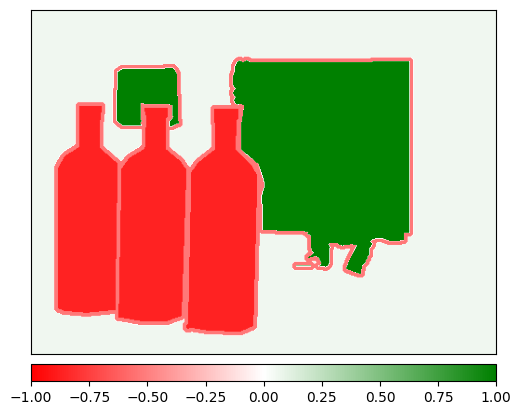

In [71]:
attribution_map = ablator.attribute(
    inputs=img_to_resnet_input(img).unsqueeze(0),
    target=664,
    feature_mask=torch.tensor(feature_mask)
)

attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels
attribution_map = np.transpose(attribution_map, (1,2,0))

_ = viz.visualize_image_attr(
    attr=attribution_map,
    method="heat_map",  # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    sign="all",         # [positive, absolute_value, negative, all]
    show_colorbar=True
)

Captum has computed the influence of each feature groups on the target `monitor`:
* The TV monitors are expectedly the most influential part.
* The background has no infuential.
* The borders seem to have some negative impact. Ablating them slightly boosts the target, possibly because this helps framing the monitors in the image?
* The bottles have a considerable negative impact. Ablating them apparently makes the monitors stand out as the main object in the image, which in turns boosts the activation for this target.

You can verify this finding next if you are interested.

---

Captum 计算了每个功能组对目标 `monitor` 的影响：
* 电视显示器预计是最有影响力的部分。
* 背景无影响。
* 边界似乎有一些负面影响。 消融它们会稍微增强目标，可能是因为这有助于在图像中构建监视器？
* 瓶子有相当大的负面影响。 显然，消融它们会使监视器作为图像中的主要对象脱颖而出，从而增强了该目标的激活。

如果您有兴趣，接下来可以验证这一发现。

## 5. Sanity check: re-classifying after ablation

Here we use OpenCV's `bitwise_and` to create an image with ablated bottles and borders:

---

这里我们使用 OpenCV 的 `bitwise_and` 来创建一个带有消融瓶子和边框的图像：

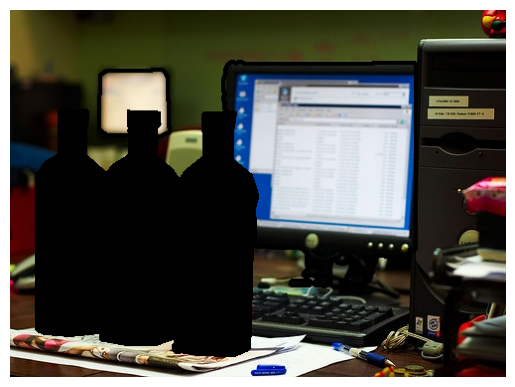

In [72]:
import cv2

cv2_mask = np.array(feature_mask)
cv2_mask[feature_mask == 0] = 1
cv2_mask[feature_mask == 1] = 0
cv2_mask[feature_mask == 2] = 1
cv2_mask[feature_mask == 3] = 0
cv2_mask = np.expand_dims(cv2_mask.squeeze(), axis=2).astype(np.uint8)

img_arr = np.transpose(T.ToTensor()(img).numpy(),  (1,2,0))
img_without_bottles = cv2.bitwise_and(img_arr, img_arr, mask=cv2_mask)
plt.imshow(img_without_bottles); plt.axis('off'); plt.show()

Let us classify this ablated image:

In [75]:
classify(img_without_bottles)

Predicted: desktop_computer id = 527 with a score of: 0.10780549794435501


(527, 0.10780549794435501)

The output is `desktop_computer`, another class in ImageNet whose images usuallly include a monitor and a keyboard. Not bad.

In fact, the `monitor` class (with id = 664) is among the top-5 guesses:

---

输出是 `desktop_computer`，ImageNet 中的另一个类，其图像通常包括显示器和键盘。 不错。

事实上，`monitor` 类（id = 664）是排名前 5 的猜测之一：

In [76]:
output = resnet(img_to_resnet_input(img_without_bottles).unsqueeze(0))
output = F.softmax(output, dim=1)
torch.topk(output, 5)

torch.return_types.topk(
values=tensor([[0.1078, 0.0952, 0.0899, 0.0822, 0.0745]], grad_fn=<TopkBackward0>),
indices=tensor([[527, 681, 673, 782, 664]]))